<a href="https://colab.research.google.com/github/evalcas/climate-variables-senamhi-augusto-weberbauer-cajamarca-1994-2024/blob/main/Dataset_Imputation_Senamhi30Year.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Procesamiento y Comparación de Métodos de Imputación en Datos Climatológicos - Estación Augusto Weberbauer (Cajamarca, Perú)

* Objetivo del Notebook: Realizar una evaluación exhaustiva de siete métodos de imputación aplicados a series temporales climatológicas diarias de 30 años

* Fuente de Datos: Los datos fueron proporcionados por el SENAMHI para la ciudad de Cajamarca en Perú, el periodo abarca desde enero del 1994 a diciembre del 2024.

* Variables Climatológicas Procesadas y Evaluadas:
  * precipitación
  * temperatura
  * humedad
  * presión atmosférica
  * velocidad del viento
  * horas de sol
* Repositorio y Autoría:
Edwin Valencia-Castillo, & Sandra Rodriguez-Avila. (2025). Climate Variables from SENAMHI Augusto Weberbauer Station (Cajamarca, Peru), 1994–2024 (v1.1.0). Zenodo. https://doi.org/10.5281/zenodo.15803715

In [2]:
# --- LIBRERÍAS ---
import pandas as pd
from sklearn.impute import KNNImputer
import numpy as np
from scipy.interpolate import interp1d
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import time

# Importa el módulo de advertencias para controlar la visualización de warnings durante la ejecución
import warnings
# Ignora específicamente las advertencias de tipo FutureWarning que podrían aparecer al utilizar funciones
# que cambiarán en versiones futuras de bibliotecas como pandas o numpy.
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
# URL del archivo Excel en GitHub

url = 'https://github.com/evalcas/climate-variables-senamhi-augusto-weberbauer-cajamarca-1994-2024/blob/main/dataset_preprocessed_senamhi30Year.xlsx?raw=true'
excel_file = url

df_procesado = pd.read_excel(excel_file)

In [4]:
print(df_procesado.head())

  ProcessDate  Year  Month  Day  DailyPrecipitation  AverageTemperature  \
0  1994-01-01  1994      1    1                 0.2                14.9   
1  1994-01-02  1994      1    2                 7.7                15.1   
2  1994-01-03  1994      1    3                 0.0                14.0   
3  1994-01-04  1994      1    4                 0.0                15.3   
4  1994-01-05  1994      1    5                 5.1                15.1   

   RelativeHumidity  AtmosphericPressure  WindSpeed  SunshineHours  
0              76.2                740.1        1.3            6.8  
1              77.8                739.9        1.3            1.6  
2              73.1                739.5        1.7            6.8  
3              66.9                740.2        NaN            3.5  
4              72.0                740.1        2.0            6.2  


In [5]:
# usando df_procesado crea un indice fecha utilizando la columna ProcessDate
# verifica que no haya fechas faltantes, si los hay visualizalos
# luego muestra los datos faltantes del df_procesado

# Establecer 'ProcessDate' como índice
df_procesado = df_procesado.set_index('ProcessDate')

# Verificar fechas faltantes
fechas_minima = df_procesado.index.min()
fechas_maxima = df_procesado.index.max()

rango_fechas = pd.date_range(start=fechas_minima, end=fechas_maxima)
fechas_faltantes = rango_fechas.difference(df_procesado.index)

if not fechas_faltantes.empty:
  print("Fechas faltantes:")
  print(fechas_faltantes)
else:
  print("No hay fechas faltantes en el DataFrame.")

# Mostrar datos faltantes en el DataFrame
print("\nDatos faltantes en df_procesado:")
print(df_procesado.isna().sum())

No hay fechas faltantes en el DataFrame.

Datos faltantes en df_procesado:
Year                      0
Month                     0
Day                       0
DailyPrecipitation      137
AverageTemperature      396
RelativeHumidity        508
AtmosphericPressure     327
WindSpeed              1288
SunshineHours           163
dtype: int64


In [6]:
# muestra informacion de los valores faltantes relacionados a su proporcion y distribucion expresado en porcentaje de la variables del dataset df_procesado

# Calcular el porcentaje de valores faltantes por columna
missing_percentage = df_procesado.isnull().sum() * 100 / len(df_procesado)

# Crear un DataFrame para mostrar la información
missing_info = pd.DataFrame({
    'Variable': missing_percentage.index,
    'Valores Faltantes': df_procesado.isnull().sum().values,
    'Porcentaje de Valores Faltantes': missing_percentage.values
})

# Ordenar por porcentaje de valores faltantes (de mayor a menor)
missing_info = missing_info.sort_values(by='Porcentaje de Valores Faltantes', ascending=False)

# Mostrar la información
missing_info


,Variable,Valores Faltantes,Porcentaje de Valores Faltantes
7,WindSpeed,1288,11.375077
5,RelativeHumidity,508,4.486444
4,AverageTemperature,396,3.497306
6,AtmosphericPressure,327,2.887927
8,SunshineHours,163,1.439548
3,DailyPrecipitation,137,1.209927
0,Year,0,0.000000
1,Month,0,0.000000
2,Day,0,0.000000


In [7]:
df_procesado.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11323 entries, 1994-01-01 to 2024-12-31
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year                 11323 non-null  int64  
 1   Month                11323 non-null  int64  
 2   Day                  11323 non-null  int64  
 3   DailyPrecipitation   11186 non-null  float64
 4   AverageTemperature   10927 non-null  float64
 5   RelativeHumidity     10815 non-null  float64
 6   AtmosphericPressure  10996 non-null  float64
 7   WindSpeed            10035 non-null  float64
 8   SunshineHours        11160 non-null  float64
dtypes: float64(6), int64(3)
memory usage: 884.6 KB


# Introducción a la Imputación de Datos Faltantes

Las series temporales climatológicas son una fuente de información invaluable para diversos campos de investigación. Sin embargo, estas series frecuentemente presentan datos faltantes debido a factores como fallos en los instrumentos de medición, errores humanos durante la recolección o condiciones ambientales adversas que imposibilitan la toma de datos, como la pandemia de COVID-19.

La presencia de estos vacíos puede comprometer significativamente la calidad y fiabilidad de los análisis posteriores, introduciendo sesgos en la modelización y afectando la precisión de las predicciones climatológicas.

La imputación de datos faltantes en series temporales climatológicas representa un desafío particular debido a la naturaleza compleja de estas series, caracterizadas por componentes de tendencia, estacionalidad, ciclicidad y patrones de autocorrelación específicos. Además, variables como la precipitación presentan distribuciones no normales con alta frecuencia de valores cero, mientras que otras como la temperatura exhiben marcados patrones estacionales.

Se han propuesto diversos métodos para abordar este problema, desde técnicas clásicas como la interpolación lineal y la media móvil, hasta enfoques más sofisticados basados en descomposición temporal, k-vecinos más cercanos (KNN) y técnicas de imputación múltiple. Este estudio se centra en una evaluación exhaustiva de siete métodos de imputación aplicados a series temporales climatológicas diarias de 30 años de la ciudad de Cajamarca, Perú.

---

# Métodos de Imputación Evaluados

## 1. Imputación Estacional (Promedio Histórico)

**Descripción:**  
Este método utiliza la naturaleza cíclica de muchas variables ambientales. Un valor faltante se reemplaza por el promedio de los valores correspondientes a la misma fecha en otros años disponibles.

**Principio Matemático:**  
Sea una serie temporal $Y = y_1, y_2, \ldots, y_N$ con un período estacional $s$, el valor imputado $y'_t$ se calcula como:

$$
y'_t = \frac{1}{2n} \sum_{i=1}^{n} (y_{t - i \cdot s} + y_{t + i \cdot s})
$$
**Ventajas:**
- Preserva la estacionalidad.
- Fácil de implementar.
- Utiliza datos reales del histórico.
- Intuitivo para datos meteorológicos.
- Buen desempeño en variables como precipitación y viento.

**Limitaciones:**
- No considera eventos atípicos (e.g., años extremos).
- Puede suavizar variaciones interanuales.

---

## 2. Imputación por Interpolación Temporal

**Descripción:**  
Estima valores faltantes usando funciones matemáticas derivadas de los puntos antes y después de la brecha. Se empleó interpolación cúbica spline.

**Principio Matemático:**  
Para el intervalo $[x_i, x_{i+1}]$:

$$
S_i(x) = a_i + b_i(x - x_i) + c_i(x - x_i)^2 + d_i(x - x_i)^3
$$

**Limitaciones:**
- Introduce sesgos en distribución y densidad.
- Tiende a suavizar excesivamente la serie.

---

## 3. Imputación por Interpolación Lineal

**Descripción:**  
Usa una combinación lineal entre las observaciones adyacentes.

**Principio Matemático:**

$$
y'_t = y_{t-k} + \frac{t - (t - k)}{(t + m) - (t - k)} \cdot (y_{t+m} - y_{t-k})
$$

**Limitaciones:**
- Suaviza excesivamente la serie.
- Reduce la variabilidad y distorsiona la distribución.
- Mal desempeño con variables extremas como precipitación.

---

## 4. Imputación por Descomposición Temporal

**Descripción:**  
Descompone la serie en tendencia, estacionalidad y residuales. Se usó la técnica STL (Seasonal-Trend decomposition using LOESS).

**Principio Matemático:**

$$
Y_t = T_t + S_t + R_t
$$

$$
y'_t = T'_t + S'_t + R''_t
$$

Donde:
- $T'_t$: estimado con LOESS.
- $S'_t$: estimado con medias móviles.
- $R''_t$: estimado con KNN sobre residuos.

**Ventajas:**
- Preserva componentes individuales (tendencia, estacionalidad, residuales).
- Mantiene estructura de dependencia temporal.
- Reconstruye patrones no lineales.
- Mejor desempeño general según el estudio.

---

## 5. Imputación K-Nearest Neighbors (KNN)

**Descripción:**  
Imputa valores faltantes usando observaciones similares en un espacio multidimensional.

**Principio Matemático:**

$$
d(x_i, x_j) = \sqrt{\sum_{k=1}^{p} w_k (x_{ik} - x_{jk})^2}
$$

$$
y'_t = \frac{\sum_{i=1}^k w_i y_i}{\sum_{i=1}^k w_i}, \quad \text{donde} \quad w_i = \frac{1}{d_i}
$$

**Limitaciones:**
- No incorpora explícitamente la estructura temporal.
- Desempeño intermedio; mejora en variables más estables.

---

## 6. Imputación MICE (Multiple Imputation by Chained Equations)

**Descripción:**  
Utiliza múltiples imputaciones con un proceso iterativo de ecuaciones encadenadas.

**Principio Matemático:**

$$
P(Y_j \mid Y_{-j}, R, \phi_j)
$$

**Proceso:**
1. Inicializa con imputaciones simples.
2. Para cada variable:
   - Actualiza los parámetros del modelo.
   - Imputa usando el modelo actualizado.
3. Repite hasta convergencia.

**Ventajas:**
- Incorpora múltiples variables y sus correlaciones.
- Buen desempeño en estadísticas y métricas de complejidad.

**Limitaciones:**
- Peor que la descomposición temporal en dinámica temporal.
- Puede generar valores fuera de rango en casos específicos.

---

## 7. Imputación por Media Móvil

**Descripción:**  
Imputa usando el promedio de un conjunto de valores vecinos dentro de una ventana.

**Principio Matemático:**

$$
y'_t = \frac{1}{|\Omega_t|} \sum_{i \in \Omega_t} y_i
$$

Donde $ \Omega_t $ es el conjunto de índices dentro de la ventana $ [t - w/2, t + w/2] $ con datos observados.

**Limitaciones:**
- Suaviza excesivamente la serie.
- Distorsiona distribución, especialmente en eventos extremos.
- Peor desempeño según los resultados del estudio.

---


In [8]:
# Implementacion de los Metodos de imputacion estudiados
# --- FUNCIONES AUXILIARES ---

def reporte_imputacion(df_imputado, columnas_a_imputar, datos_imputados_totales):
    cantidad_faltantes_final = df_imputado[columnas_a_imputar].isnull().sum()
    print("\nCantidad final de datos faltantes por variable:")
    print(cantidad_faltantes_final)

    print("\nCantidad total de datos imputados por variable:")
    for columna in columnas_a_imputar:
        cantidad = datos_imputados_totales.get(columna, 0)
        print(f"  {columna}: {cantidad} imputados")

def contar_imputados(df_original, df_imputado, columnas_a_imputar):
    imputaciones = {}
    for col in columnas_a_imputar:
        antes = df_original[col].isnull().sum()
        despues = df_imputado[col].isnull().sum()
        imputaciones[col] = antes - despues
    return imputaciones

# --- MÉTODOS DE IMPUTACIÓN ---

def promedio_historico(df, columnas_a_imputar):
    print("--- Iniciando la imputación por promedio histórico ---")
    df_imputado = df.copy()
    start_time = time.time()
    for columna in columnas_a_imputar:
        for (month, day), grupo in df.groupby(['Month', 'Day']):
            promedio = grupo[columna].mean(skipna=True)
            mask = (df_imputado['Month'] == month) & (df_imputado['Day'] == day) & (df_imputado[columna].isnull())
            df_imputado.loc[mask, columna] = promedio
    end_time = time.time()
    print(f"Imputación por promedio histórico completada en {end_time - start_time:.2f} segundos")
    datos_imputados = contar_imputados(df, df_imputado, columnas_a_imputar)
    reporte_imputacion(df_imputado, columnas_a_imputar, datos_imputados)
    return df_imputado

def interpolacion_temporal(df, columnas_a_imputar):
    start_time = time.time()
    df_interpolated = df.copy()
    df_interpolated[columnas_a_imputar] = df[columnas_a_imputar].interpolate(method='time')
    end_time = time.time()
    print(f"Interpolación Temporal: {end_time - start_time:.2f} segundos")
    datos_imputados = contar_imputados(df, df_interpolated, columnas_a_imputar)
    reporte_imputacion(df_interpolated, columnas_a_imputar, datos_imputados)
    return df_interpolated

def interpolacion_lineal(df, columnas_a_imputar):
    start_time = time.time()
    df_interpolated = df.copy()
    df_interpolated[columnas_a_imputar] = df[columnas_a_imputar].interpolate(method='linear')
    end_time = time.time()
    print(f"Interpolación Lineal: {end_time - start_time:.2f} segundos")
    datos_imputados = contar_imputados(df, df_interpolated, columnas_a_imputar)
    reporte_imputacion(df_interpolated, columnas_a_imputar, datos_imputados)
    return df_interpolated

def descomposicion_temporal_clasica(df, columnas_a_imputar, period=365):
    start_time = time.time()
    df_imputed = df.copy()
    for col in columnas_a_imputar:
        serie_original = df[col]
        missing_mask = serie_original.isna()
        serie_interpolada = serie_original.interpolate(method='linear', limit_direction='both')
        result = seasonal_decompose(serie_interpolada, model='additive', period=period, extrapolate_trend='freq')
        serie_reconstruida = result.trend + result.seasonal + result.resid
        serie_imputada = serie_original.copy()
        serie_imputada[missing_mask] = serie_reconstruida[missing_mask]
        df_imputed[col] = serie_imputada
    end_time = time.time()
    print(f"Descomposición temporal clásica: {end_time - start_time:.2f} segundos")
    datos_imputados = contar_imputados(df, df_imputed, columnas_a_imputar)
    reporte_imputacion(df_imputed, columnas_a_imputar, datos_imputados)
    return df_imputed

def descomposicion_temporal(df, columnas_a_imputar):
    start_time = time.time()
    df_imputed = df.copy()
    for col in columnas_a_imputar:
        serie = df[col]
        serie_interpolada = serie.interpolate(method='linear', limit_direction='both')
        stl = STL(serie_interpolada, period=365)
        result = stl.fit()
        imputacion = result.trend + result.seasonal + result.resid
        df_imputed[col] = serie.copy()
        df_imputed[col][serie.isna()] = imputacion[serie.isna()]
    end_time = time.time()
    print(f"Descomposición STL con imputación: {end_time - start_time:.2f} segundos")
    datos_imputados = contar_imputados(df, df_imputed, columnas_a_imputar)
    reporte_imputacion(df_imputed, columnas_a_imputar, datos_imputados)
    return df_imputed

def knn_imputation(df, columnas_a_imputar, n_neighbors=5):
    start_time = time.time()
    knn = KNeighborsRegressor(n_neighbors=n_neighbors)
    df_imputed = df.copy()
    for col in columnas_a_imputar:
        missing = df[col].isnull()
        if missing.any():
            X = df.index[~missing].values.reshape(-1, 1)
            y = df[col][~missing].values
            knn.fit(X, y)
            df_imputed.loc[missing, col] = knn.predict(df.index[missing].values.reshape(-1, 1))
    end_time = time.time()
    print(f"KNN Imputation: {end_time - start_time:.2f} segundos")
    datos_imputados = contar_imputados(df, df_imputed, columnas_a_imputar)
    reporte_imputacion(df_imputed, columnas_a_imputar, datos_imputados)
    return df_imputed

def mice_imputation(df, columnas_a_imputar):
    start_time = time.time()
    mice_imputer = IterativeImputer(max_iter=10, random_state=42)
    df_imputed = pd.DataFrame(mice_imputer.fit_transform(df), columns=df.columns, index=df.index)
    end_time = time.time()
    print(f"MICE Imputation: {end_time - start_time:.2f} segundos")
    datos_imputados = contar_imputados(df, df_imputed, columnas_a_imputar)
    reporte_imputacion(df_imputed, columnas_a_imputar, datos_imputados)
    return df_imputed

# La imputacion con media movil basica no funciona cuando se tienen periodos largos como en covid19
# Se sugiere una media movil y una estrategia combinada
# Aplicar media móvil centrada para imputar valores donde haya datos alrededor.
# Aplicar interpolación lineal para bloques faltantes donde la media móvil falló.
# Aplicar forward/backward fill como último recurso (solo si queda algo faltante).
def media_movil_estacional_completa(df, columnas_a_imputar, ventana=7):
    start_time = time.time()
    df_imputed = df.copy()
    df_original = df.copy()

    for col in columnas_a_imputar:
        serie = df[col]

        # Paso 1: Imputación con media móvil centrada
        rolling_mean = serie.rolling(window=ventana, center=True, min_periods=1).mean()
        imputados_mm = serie.isna() & rolling_mean.notna()
        df_imputed.loc[imputados_mm, col] = rolling_mean[imputados_mm]

        # Paso 2: Interpolación lineal donde aún haya NaN
        serie_interpolada = df_imputed[col].interpolate(method='linear', limit_direction='both')

        # Paso 3: Relleno forward/backward si aún quedan NaNs
        serie_final = serie_interpolada.fillna(method='ffill').fillna(method='bfill')

        df_imputed[col] = serie_final

    end_time = time.time()
    print(f"\nMedia Móvil Estacional Completa: {end_time - start_time:.2f} segundos")

    # Reporte
    datos_imputados = contar_imputados(df_original, df_imputed, columnas_a_imputar)
    reporte_imputacion(df_imputed, columnas_a_imputar, datos_imputados)

    return df_imputed



# --- PARÁMETROS Y APLICACIÓN ---

# Asegúrate que esto exista antes:
# df_procesado = dataframe original con columnas 'Year', 'Month', 'Day' y las variables

columnas_a_imputar = ['DailyPrecipitation', 'AverageTemperature', 'RelativeHumidity', 'AtmosphericPressure', 'WindSpeed', 'SunshineHours']
df_procesado = df_procesado.sort_values(by=["Year", "Month", "Day"])
df_procesado_estacional = df_procesado[columnas_a_imputar]

print("DataFrame original antes de la imputación (primeras filas):")
print(df_procesado.head())

df_imputacion_estacional = promedio_historico(df_procesado.copy(), columnas_a_imputar)
df_imputacion_interpolacion_temporal = interpolacion_temporal(df_procesado_estacional.copy(), columnas_a_imputar)
df_imputacion_interpolacion_lineal = interpolacion_lineal(df_procesado_estacional.copy(), columnas_a_imputar)
df_imputacion_descomposicion_temporal = descomposicion_temporal(df_procesado_estacional.copy(), columnas_a_imputar)
df_imputacion_knn = knn_imputation(df_procesado_estacional.copy(), columnas_a_imputar)
df_imputacion_mice = mice_imputation(df_procesado_estacional.copy(), columnas_a_imputar)
df_imputacion_media_movil = media_movil_estacional_completa(df_procesado_estacional.copy(), columnas_a_imputar)


DataFrame original antes de la imputación (primeras filas):
             Year  Month  Day  DailyPrecipitation  AverageTemperature  \
ProcessDate                                                             
1994-01-01   1994      1    1                 0.2                14.9   
1994-01-02   1994      1    2                 7.7                15.1   
1994-01-03   1994      1    3                 0.0                14.0   
1994-01-04   1994      1    4                 0.0                15.3   
1994-01-05   1994      1    5                 5.1                15.1   

             RelativeHumidity  AtmosphericPressure  WindSpeed  SunshineHours  
ProcessDate                                                                   
1994-01-01               76.2                740.1        1.3            6.8  
1994-01-02               77.8                739.9        1.3            1.6  
1994-01-03               73.1                739.5        1.7            6.8  
1994-01-04               66.9    

# EVALUACION DE LA IMPUTACION

## 1. EVALUACION ESTADISTICA Y VISUAL

Comparacion de Rangos y distribucion

* Rangos Históricos: Comprueba que los valores imputados se encuentren dentro de rangos razonables comparados con datos históricos.
* Estadísticas Descriptivas: Revisa la media, mediana, varianza, etc., antes y después de la imputación para detectar posibles sesgos.
* Histogramas y Densidades: Grafica histogramas de la serie original e imputada para verificar que la forma de la distribución se mantenga.


## Rangos Historicos

Se calcula los valores mínimos y máximos históricos de cada variable y verificar que los valores imputados se mantengan dentro de ese rango.

Si hay valores fuera del rango histórico, podrías revisar si la imputación es adecuada.

In [9]:
# Rangos historicos con porcentajes de valores fueran de rango

def generar_tabla_rangos(df_original, df_imputados, columnas):
    """
    Genera una tabla de rangos históricos con porcentajes de valores fuera de rango para cada método de imputación.

    Args:
        df_original: DataFrame original sin imputar.
        df_imputados: Diccionario con los DataFrames imputados, donde la clave es el nombre del método.
        columnas: Lista de columnas a evaluar.

    Returns:
        pandas.DataFrame: Tabla resumen con los resultados.
    """

    resultados = []
    for nombre_metodo, df_imputado in df_imputados.items():
        for columna in columnas:
            min_historico = df_original[columna].min()
            max_historico = df_original[columna].max()

            fuera_rango = df_imputado[
                (df_imputado[columna] < min_historico) |
                (df_imputado[columna] > max_historico)
            ]
            porcentaje_fuera_rango = (len(fuera_rango) / len(df_imputado)) * 100 if len(df_imputado) > 0 else 0

            resultados.append({
                'Método de Imputación': nombre_metodo,
                'Variable': columna,
                'Mínimo Histórico': min_historico,
                'Máximo Histórico': max_historico,
                'Valores Fuera de Rango': len(fuera_rango),
                'Porcentaje Fuera de Rango': porcentaje_fuera_rango
            })
    return pd.DataFrame(resultados)


# Crear un diccionario con los DataFrames imputados
dataframes_imputados = {
    'Estacional': df_imputacion_estacional,
    'Interpolación Temporal': df_imputacion_interpolacion_temporal,
    'Interpolación Lineal': df_imputacion_interpolacion_lineal,
    'Descomposición Temporal': df_imputacion_descomposicion_temporal,
    'KNN': df_imputacion_knn,
    'MICE': df_imputacion_mice,
    'Media Móvil': df_imputacion_media_movil
}

# Generar y mostrar la tabla de rangos
tabla_rangos = generar_tabla_rangos(df_procesado, dataframes_imputados, columnas_a_imputar)
tabla_rangos


,Método de Imputación,Variable,Mínimo Histórico,Máximo Histórico,Valores Fuera de Rango,Porcentaje Fuera de Rango
0,Estacional,DailyPrecipitation,0.0,51.8,0,0.000000
1,Estacional,AverageTemperature,10.6,18.5,0,0.000000
2,Estacional,RelativeHumidity,29.9,93.9,0,0.000000
3,Estacional,AtmosphericPressure,736.6,749.7,0,0.000000
4,Estacional,WindSpeed,0.0,8.3,0,0.000000
5,Estacional,SunshineHours,0.0,12.3,0,0.000000
6,Interpolación Temporal,DailyPrecipitation,0.0,51.8,0,0.000000
7,Interpolación Temporal,AverageTemperature,10.6,18.5,0,0.000000
8,Interpolación Temporal,RelativeHumidity,29.9,93.9,0,0.000000
9,Interpolación Temporal,AtmosphericPressure,736.6,749.7,0,0.000000


In [10]:
# Diferencias relativas en la media por cada metodo y variable entre series originales e imputadas

def generar_tabla_diferencias_relativas(df_original, df_imputados, columnas):
    """
    Genera una tabla con las diferencias relativas en la media para cada método de imputación,
    formateada a cuatro decimales.

    Args:
        df_original: DataFrame original sin imputar.
        df_imputados: Diccionario con los DataFrames imputados, donde la clave es el nombre del método.
        columnas: Lista de columnas a evaluar.

    Returns:
        pandas.DataFrame: Tabla resumen con los resultados.
    """

    resultados = []
    for nombre_metodo, df_imputado in df_imputados.items():
        fila = {'Metodo de interpolacion': nombre_metodo}
        for columna in columnas:
            media_original = df_original[columna].mean()
            media_imputada = df_imputado[columna].mean()

            if media_original == 0:
                diferencia_relativa = 0  # Evitar división por cero
            else:
                diferencia_relativa = ((media_imputada - media_original) / media_original) * 100

            fila[columna] = round(diferencia_relativa, 4) # Formato a 4 decimales
        resultados.append(fila)
    return pd.DataFrame(resultados)

# Usar la función para generar la tabla
tabla_diferencias = generar_tabla_diferencias_relativas(df_procesado, dataframes_imputados, columnas_a_imputar)
tabla_diferencias


,Metodo de interpolacion,DailyPrecipitation,AverageTemperature,RelativeHumidity,AtmosphericPressure,WindSpeed,SunshineHours
0,Estacional,0.0656,0.0430,0.0812,-0.0004,-0.0302,-0.0334
1,Interpolación Temporal,-0.2949,0.0618,0.1237,-0.0025,-2.9636,-0.3981
2,Interpolación Lineal,-0.2949,0.0618,0.1237,-0.0025,-2.9636,-0.3981
3,Descomposición Temporal,-0.2949,0.0618,0.1237,-0.0025,-2.9636,-0.3981
4,KNN,0.3209,0.0977,0.0950,-0.0020,-1.3175,-0.1742
5,MICE,-0.0195,0.0130,0.1677,-0.0003,-0.3551,0.0028
6,Media Móvil,-0.2910,0.0663,0.1154,-0.0025,-2.9445,-0.3760


In [11]:
# Diferencias relativas en la desviacion estandar por cada metodo y variable. La tabla a generar debe seguir la estructura: Metodo de interpolacion, Temperatura, Precipitacion, Humedad, Presion, Viento, Horas Sol, y en cada fila mostrar el metodo y por cada variable la diferencia relativa en % a cinco digitos

def generar_tabla_diferencias_relativas_std(df_original, df_imputados, columnas):
    """
    Genera una tabla con las diferencias relativas en la desviación estándar para cada método de imputación,
    formateada a cinco decimales.

    Args:
        df_original: DataFrame original sin imputar.
        df_imputados: Diccionario con los DataFrames imputados, donde la clave es el nombre del método.
        columnas: Lista de columnas a evaluar.

    Returns:
        pandas.DataFrame: Tabla resumen con los resultados.
    """

    resultados = []
    for nombre_metodo, df_imputado in df_imputados.items():
        fila = {'Metodo de interpolacion': nombre_metodo}
        for columna in columnas:
            std_original = df_original[columna].std()
            std_imputada = df_imputado[columna].std()

            if std_original == 0:
                diferencia_relativa = 0  # Evitar división por cero
            else:
                diferencia_relativa = ((std_imputada - std_original) / std_original) * 100

            fila[columna] = round(diferencia_relativa, 4)  # Formato a 5 decimales
        resultados.append(fila)
    return pd.DataFrame(resultados)

# Usar la función para generar la tabla
tabla_diferencias_std = generar_tabla_diferencias_relativas_std(df_procesado, dataframes_imputados, columnas_a_imputar)
tabla_diferencias_std


,Metodo de interpolacion,DailyPrecipitation,AverageTemperature,RelativeHumidity,AtmosphericPressure,WindSpeed,SunshineHours
0,Estacional,-0.5194,-1.4670,-1.7823,-1.2950,-5.1155,-0.6298
1,Interpolación Temporal,-0.5429,-0.8211,-0.6830,0.2657,-3.0138,-0.2316
2,Interpolación Lineal,-0.5429,-0.8211,-0.6830,0.2657,-3.0138,-0.2316
3,Descomposición Temporal,-0.5429,-0.8211,-0.6830,0.2657,-3.0138,-0.2316
4,KNN,-0.5485,-0.9465,-0.8709,0.6034,-5.1077,-0.5349
5,MICE,-0.5990,-1.6706,-0.9803,-1.4132,-4.9735,-0.6371
6,Media Móvil,-0.5340,-0.8808,-0.8854,0.2766,-3.0965,-0.2826


In [12]:
# Diferencias relativas en la asimetria por cada metodo y variable. La tabla a generar debe seguir la estructura: Metodo de interpolacion, Temperatura, Precipitacion, Humedad, Presion, Viento, Horas Sol, y en cada fila mostrar el metodo y por cada variable la diferencia relativa en % a cinco digitos

def generar_tabla_diferencias_relativas_asimetria(df_original, df_imputados, columnas):
    """
    Genera una tabla con las diferencias relativas en la asimetría para cada método de imputación,
    formateada a cinco decimales.

    Args:
        df_original: DataFrame original sin imputar.
        df_imputados: Diccionario con los DataFrames imputados, donde la clave es el nombre del método.
        columnas: Lista de columnas a evaluar.

    Returns:
        pandas.DataFrame: Tabla resumen con los resultados.
    """

    resultados = []
    for nombre_metodo, df_imputado in df_imputados.items():
        fila = {'Metodo de interpolacion': nombre_metodo}
        for columna in columnas:
            asimetria_original = skew(df_original[columna].dropna()) #Usar dropna para evitar errores con datos faltantes
            asimetria_imputada = skew(df_imputado[columna].dropna())

            if asimetria_original == 0:
                diferencia_relativa = 0  # Evitar división por cero
            else:
                diferencia_relativa = ((asimetria_imputada - asimetria_original) / asimetria_original) * 100

            fila[columna] = round(diferencia_relativa, 4)  # Formato a 5 decimales
        resultados.append(fila)
    return pd.DataFrame(resultados)

# Usar la función para generar la tabla
tabla_diferencias_asimetria = generar_tabla_diferencias_relativas_asimetria(df_procesado, dataframes_imputados, columnas_a_imputar)
tabla_diferencias_asimetria


,Metodo de interpolacion,DailyPrecipitation,AverageTemperature,RelativeHumidity,AtmosphericPressure,WindSpeed,SunshineHours
0,Estacional,0.3378,206.2538,6.1197,1.7113,4.1547,3.8915
1,Interpolación Temporal,0.5445,130.3462,9.8493,-2.0992,10.0868,37.0990
2,Interpolación Lineal,0.5445,130.3462,9.8493,-2.0992,10.0868,37.0990
3,Descomposición Temporal,0.5445,130.3462,9.8493,-2.0992,10.0868,37.0990
4,KNN,0.3103,289.1569,7.5858,-2.8100,10.8898,21.7485
5,MICE,0.5933,62.3157,-0.9254,1.8988,4.9838,0.8691
6,Media Móvil,0.5216,173.8868,9.4010,-2.0885,10.1865,35.6948


In [13]:
# Diferencias relativas en la curtosis por cada metodo y variable. La tabla a generar debe seguir la estructura: Metodo de interpolacion, Temperatura, Precipitacion, Humedad, Presion, Viento, Horas Sol, y en cada fila mostrar el metodo y por cada variable la diferencia relativa en % a cinco digitos

def generar_tabla_diferencias_relativas_curtosis(df_original, df_imputados, columnas):
    """
    Genera una tabla con las diferencias relativas en la curtosis para cada método de imputación,
    formateada a cinco decimales.

    Args:
        df_original: DataFrame original sin imputar.
        df_imputados: Diccionario con los DataFrames imputados, donde la clave es el nombre del método.
        columnas: Lista de columnas a evaluar.

    Returns:
        pandas.DataFrame: Tabla resumen con los resultados.
    """

    resultados = []
    for nombre_metodo, df_imputado in df_imputados.items():
        fila = {'Metodo de interpolacion': nombre_metodo}
        for columna in columnas:
            curtosis_original = kurtosis(df_original[columna].dropna())
            curtosis_imputada = kurtosis(df_imputado[columna].dropna())

            if curtosis_original == 0:
                diferencia_relativa = 0  # Evitar división por cero
            else:
                diferencia_relativa = ((curtosis_imputada - curtosis_original) / curtosis_original) * 100

            fila[columna] = round(diferencia_relativa, 5)  # Formato a 5 decimales
        resultados.append(fila)
    return pd.DataFrame(resultados)

# Usar la función para generar la tabla
tabla_diferencias_curtosis = generar_tabla_diferencias_relativas_curtosis(df_procesado, dataframes_imputados, columnas_a_imputar)
tabla_diferencias_curtosis


,Metodo de interpolacion,DailyPrecipitation,AverageTemperature,RelativeHumidity,AtmosphericPressure,WindSpeed,SunshineHours
0,Estacional,1.01978,-43.01268,-3306.97588,7.00613,18.52668,-2.48628
1,Interpolación Temporal,1.28271,-11.24158,-1369.78295,-4.76176,10.16286,-0.18916
2,Interpolación Lineal,1.28271,-11.24158,-1369.78295,-4.76176,10.16286,-0.18916
3,Descomposición Temporal,1.28271,-11.24158,-1369.78295,-4.76176,10.16286,-0.18916
4,KNN,1.04882,-17.46199,-1463.52770,-7.89797,22.31743,-2.10935
5,MICE,1.43791,-56.52970,-2937.47988,8.28770,18.32636,-2.74267
6,Media Móvil,1.23940,-13.48658,-1649.86655,-4.80113,10.63801,-0.42387


In [14]:
# Evaluacion de los mejores metodos de imputacion considerando la media, desviacion estandar,asimetria y curtosis
import pandas as pd

# Lista de variables
variables = ['DailyPrecipitation', 'AverageTemperature', 'RelativeHumidity',
             'AtmosphericPressure', 'WindSpeed', 'SunshineHours']

# Diccionario de indicadores
indicadores = {
    'Media (%)': tabla_diferencias,
    'Std (%)': tabla_diferencias_std,
    'Asimetría (%)': tabla_diferencias_asimetria,
    'Curtosis': tabla_diferencias_curtosis
}

# Criterios de selección: indicador y tipo de comparación
criterios = {
    'DailyPrecipitation': ('Media (%)', 'min', 'valor más cercano a 0'),
    'AverageTemperature': ('Media (%)', 'min', 'valor más cercano a 0'),
    'RelativeHumidity': ('Asimetría (%)', 'min', 'asimetría más cercana a 0'),
    'AtmosphericPressure': ('Media (%)', 'min', 'valor más cercano a 0'),
    'WindSpeed': ('Media (%)', 'min', 'valor más cercano a 0'),
    'SunshineHours': ('Media (%)', 'min', 'valor más cercano a 0')
}

# Lista para almacenar el resumen final
resumen_mejores_metodos = []

# Análisis variable por variable
for var in variables:
    print(f"\n🔍 Variable: {var}")
    tabla = pd.DataFrame()

    for nombre_indicador, df in indicadores.items():
        tabla[nombre_indicador] = df[var]

    tabla['Método'] = indicadores['Media (%)']['Metodo de interpolacion']
    tabla = tabla[['Método'] + list(indicadores.keys())]

    print(tabla.round(3).to_string(index=False))

    # Seleccionar el mejor método con justificación
    indicador_clave, tipo, razon = criterios[var]
    valores = tabla[indicador_clave]

    if tipo == 'min':
        idx_mejor = valores.abs().idxmin()
    elif tipo == 'max':
        idx_mejor = valores.idxmax()
    else:
        raise ValueError("Tipo de comparación no válido")

    mejor_metodo = tabla.loc[idx_mejor, 'Método']
    mejor_valor = valores[idx_mejor]

    justificacion = f"{indicador_clave.lower()} = {mejor_valor:.3f}, porque tiene el {razon}"

    print(f"✅ Mejor método: {mejor_metodo} → {justificacion}")

    resumen_mejores_metodos.append({
        'Variable': var,
        'Mejor Método': mejor_metodo,
        'Indicador Evaluado': indicador_clave,
        'Valor': round(mejor_valor, 3),
        'Justificación': f"Tiene el {razon}"
    })

# Mostrar tabla resumen
df_resumen = pd.DataFrame(resumen_mejores_metodos)
print("\n📌 Resumen general de mejores métodos por variable:")
print(df_resumen.to_string(index=False))




🔍 Variable: DailyPrecipitation
                 Método  Media (%)  Std (%)  Asimetría (%)  Curtosis
             Estacional      0.066   -0.519          0.338     1.020
 Interpolación Temporal     -0.295   -0.543          0.544     1.283
   Interpolación Lineal     -0.295   -0.543          0.544     1.283
Descomposición Temporal     -0.295   -0.543          0.544     1.283
                    KNN      0.321   -0.548          0.310     1.049
                   MICE     -0.020   -0.599          0.593     1.438
            Media Móvil     -0.291   -0.534          0.522     1.239
✅ Mejor método: MICE → media (%) = -0.019, porque tiene el valor más cercano a 0

🔍 Variable: AverageTemperature
                 Método  Media (%)  Std (%)  Asimetría (%)  Curtosis
             Estacional      0.043   -1.467        206.254   -43.013
 Interpolación Temporal      0.062   -0.821        130.346   -11.242
   Interpolación Lineal      0.062   -0.821        130.346   -11.242
Descomposición Temporal    

Evaluación de Cambios en las Estadísticas Descriptivas

  En este análisis, evaluamos el impacto de la imputación de datos estacionales en las variables ambientales. Se compararon las estadísticas antes y después de la imputación, calculando los cambios porcentuales en métricas clave como media, mediana, desviación estándar, IQR (rango intercuartil), coeficiente de variación, curtosis y asimetría.


Para facilitar la interpretación de los cambios, se utilizó un código de colores basado en la magnitud del cambio porcentual:

Color	Significado
- 🔴 Rojo	Incremento alto (>10%) en una métrica tras la imputación. Ejemplo: Aumento en la media debido a valores imputados más altos.
- 🔵 Azul	Reducción significativa (<-10%), indicando que la imputación ha disminuido la variabilidad. Ejemplo: Reducción en desviación estándar.
- 🟡 Amarillo	Cambio moderado (-10% a 10%), lo que indica una variación leve en la métrica analizada.
- ⚪ Blanco	Sin cambios o cambios insignificantes, lo que indica que la imputación no alteró la métrica de manera considerable.

In [15]:
# Estadisticas descriptivas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis, skew
from tabulate import tabulate

# -------------------------------
# 1. Función para Filtrar Variables Ambientales
# -------------------------------
def filtrar_variables_ambientales(df):
    """Excluye las columnas Year, Month y Day para analizar solo las variables ambientales."""
    return df.drop(columns=["Year", "Month", "Day"], errors="ignore")

# -------------------------------
# 2. Función para Calcular Estadísticas Descriptivas
# -------------------------------
def calcular_estadisticas(df):
    """Calcula estadísticas descriptivas extendidas para cada variable numérica."""
    stats = df.describe().T
    stats["Mediana"] = df.median()
    #stats["Curtosis"] = df.apply(kurtosis)
    #stats["Asimetría"] = df.apply(skew)
    stats["IQR"] = stats["75%"] - stats["25%"]
    stats["Coef_Variacion"] = stats["std"] / stats["mean"]
    #return stats[["mean", "Mediana", "std", "min", "max", "IQR", "Coef_Variacion", "Curtosis", "Asimetría"]]
    return stats[["mean", "Mediana", "std", "min", "max", "IQR", "Coef_Variacion"]]
# -------------------------------
# 3. Función para Evaluar Cambios Estadísticos
# -------------------------------
def evaluar_cambios_estadisticos(df_original, df_imputado):
    """Compara estadísticas antes y después de la imputación en variables ambientales."""
    df_original = filtrar_variables_ambientales(df_original)
    df_imputado = filtrar_variables_ambientales(df_imputado)

    stats_antes = calcular_estadisticas(df_original)
    stats_despues = calcular_estadisticas(df_imputado)

    # Calcular diferencia porcentual
    cambios_pct = ((stats_despues - stats_antes) / stats_antes) * 100
    cambios_pct = cambios_pct.replace([np.inf, -np.inf], np.nan)

    # Unir resultados en un solo DataFrame
    df_resultado = stats_antes.join(stats_despues, rsuffix="_despues")
    df_resultado = df_resultado.join(cambios_pct, rsuffix="_cambio")

    return df_resultado.round(3), cambios_pct.round(2)

# -------------------------------
# 4. Función para Formatear Tabla con Colores ANSI
# -------------------------------
def color_valor(valor, cambio):
    """Devuelve un valor coloreado dependiendo del nivel de cambio porcentual."""
    if isinstance(valor, (int, float)):
        if cambio == 0 or np.isnan(cambio):
            return f"\033[97m{valor:.2f}%\033[0m"  # ⚪ Blanco (sin cambio)
        elif cambio > 10:
            return f"\033[91m{valor:.2f}%\033[0m"  # 🔴 Rojo (incremento alto)
        elif cambio < -10:
            return f"\033[94m{valor:.2f}%\033[0m"  # 🔵 Azul (reducción significativa)
        else:
            return f"\033[93m{valor:.2f}%\033[0m"  # 🟡 Amarillo (cambio moderado)
    return valor

def formatear_tabla(df, cambios, dataframe_name):
    """Aplica colores ANSI solo a los valores que han cambiado."""
    df_coloreado = df.copy()
    for col in cambios.columns:
        df_coloreado[col] = [color_valor(df.loc[idx, col], cambios.loc[idx, col]) for idx in df.index]

    print(f"\n📊 Comparación de Estadísticas Antes y Después de la Imputación (Variables Ambientales) para {dataframe_name}: \n")
    print(tabulate(df_coloreado, headers='keys', tablefmt='pretty'))

    # Leyenda de colores
    print("\n🔴 \033[91mIncremento alto (>10%)\033[0m | 🔵 \033[94mReducción significativa (<-10%)\033[0m | 🟡 \033[93mCambio moderado (-10% a 10%)\033[0m | ⚪ Sin cambio\033[0m")

# -------------------------------
# 5. Función para Graficar Cambios con Barras Apiladas
# -------------------------------
def graficar_cambios_barras(df_cambios):
    """Genera un gráfico de barras apiladas para mostrar cambios porcentuales en estadísticas descriptivas."""
    df_cambios = df_cambios.replace(0, np.nan)  # Ocultar valores sin cambio
    df_cambios.plot(kind='bar', figsize=(12, 6), colormap="RdYlBu_r", edgecolor='black')

    plt.axhline(0, color='black', linewidth=1)  # Línea de referencia en 0%
    plt.ylabel("Cambio porcentual (%)")
    plt.xlabel("Variables Ambientales")
    plt.title("Cambio Porcentual en las Estadísticas Descriptivas Tras la Imputación")
    plt.legend(title="Estadística", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()

# -------------------------------
# 6. Cargar Datos y Ejecutar Análisis
# -------------------------------
# Comparacion df_procesado y el dataframe imputado
df_comparacion1, cambios_pct1 = evaluar_cambios_estadisticos(df_procesado, df_imputacion_estacional)
df_comparacion2, cambios_pct2 = evaluar_cambios_estadisticos(df_procesado, df_imputacion_interpolacion_temporal)
df_comparacion3, cambios_pct3 = evaluar_cambios_estadisticos(df_procesado, df_imputacion_interpolacion_lineal)
df_comparacion7, cambios_pct7 = evaluar_cambios_estadisticos(df_procesado, df_imputacion_descomposicion_temporal)
df_comparacion4, cambios_pct4 = evaluar_cambios_estadisticos(df_procesado, df_imputacion_knn)
df_comparacion5, cambios_pct5 = evaluar_cambios_estadisticos(df_procesado, df_imputacion_mice)
df_comparacion6, cambios_pct6 = evaluar_cambios_estadisticos(df_procesado, df_imputacion_media_movil)


# Mostrar Tabla con Comparaciones
formatear_tabla(df_comparacion1, cambios_pct1, "Imputacion Estacional")
formatear_tabla(df_comparacion2, cambios_pct2, "Imputacion por interpolacion temporal")
formatear_tabla(df_comparacion3, cambios_pct3, "Imputacion por descomposicion lineal")
formatear_tabla(df_comparacion4, cambios_pct4, "Imputacion por descomposicion temporal")
formatear_tabla(df_comparacion5, cambios_pct5, "Imputacion por KNN")
formatear_tabla(df_comparacion6, cambios_pct6, "Imputacion por MICE")
formatear_tabla(df_comparacion7, cambios_pct7, "Imputacion por media movil")


# Mostrar Gráfico de Barras Apiladas
# graficar_cambios_barras(cambios_pct)


📊 Comparación de Estadísticas Antes y Después de la Imputación (Variables Ambientales) para Imputacion Estacional: 

+---------------------+---------+---------+-------+---------+---------+--------+----------------+--------------+-----------------+-------------+-------------+-------------+-------------+------------------------+-------------+----------------+------------+------------+------------+------------+-----------------------+
|                     |  mean   | Mediana |  std  |   min   |   max   |  IQR   | Coef_Variacion | mean_despues | Mediana_despues | std_despues | min_despues | max_despues | IQR_despues | Coef_Variacion_despues | mean_cambio | Mediana_cambio | std_cambio | min_cambio | max_cambio | IQR_cambio | Coef_Variacion_cambio |
+---------------------+---------+---------+-------+---------+---------+--------+----------------+--------------+-----------------+-------------+-------------+-------------+-------------+------------------------+-------------+----------------+--

# Comparacion de distribuciones y densidades
Histogramas y densidades

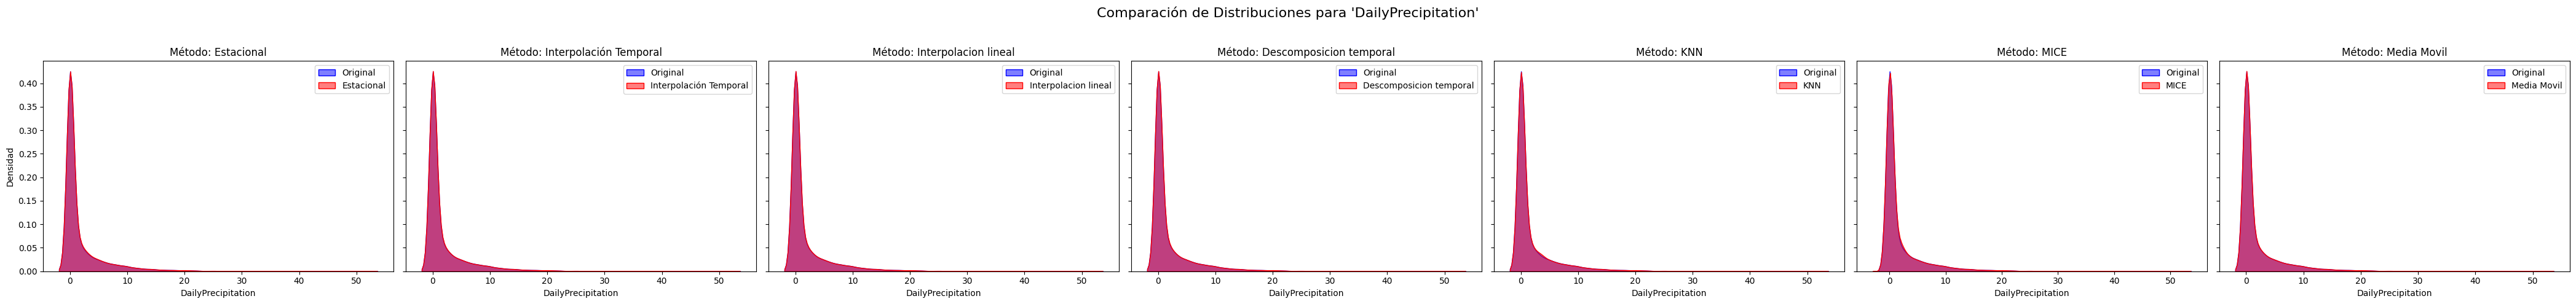

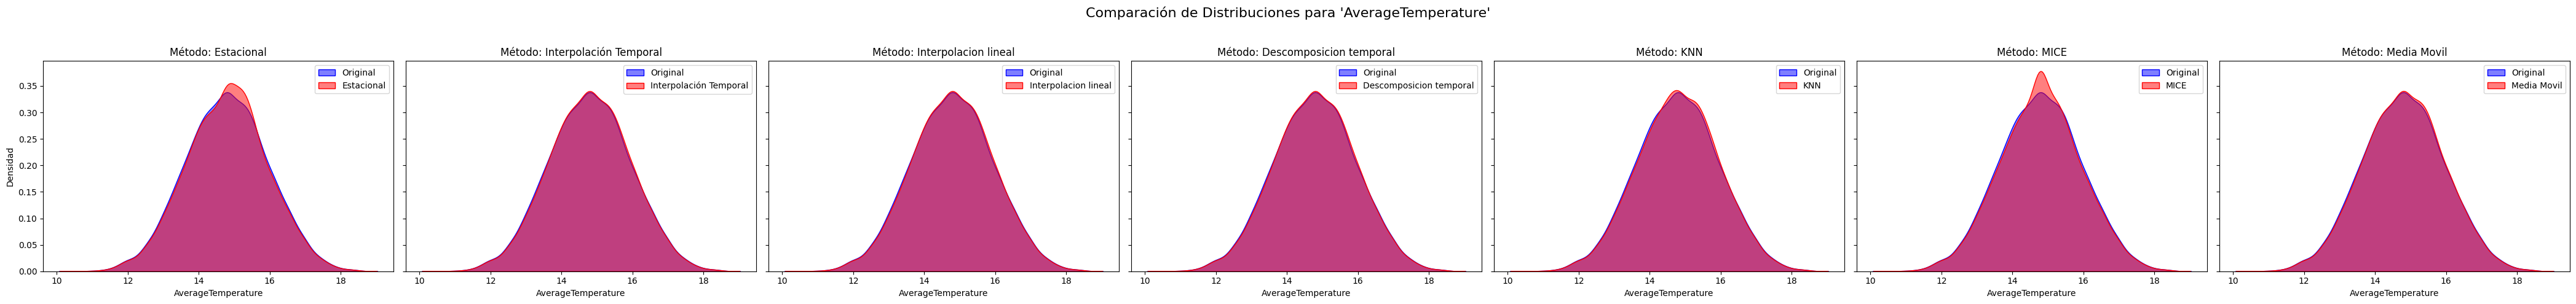

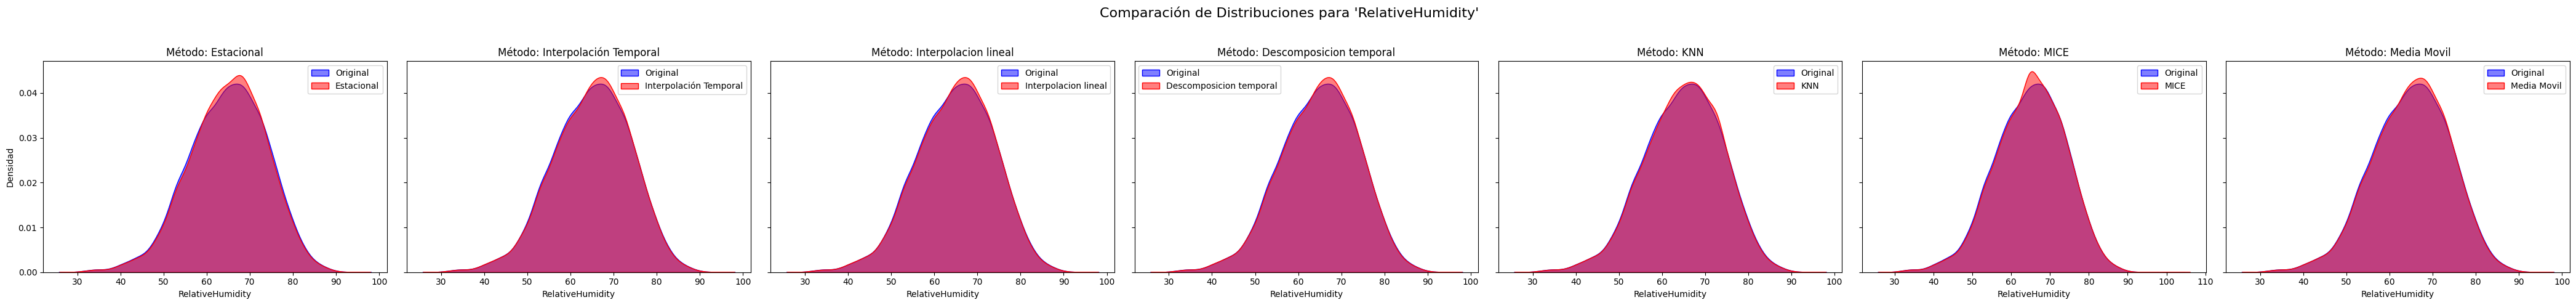

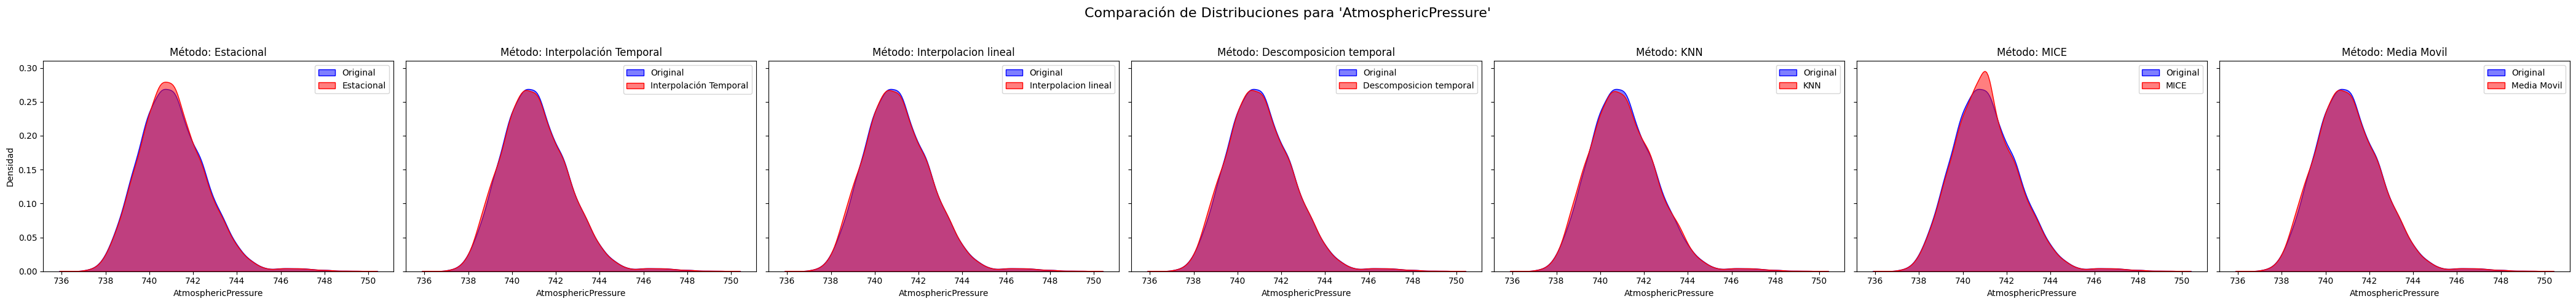

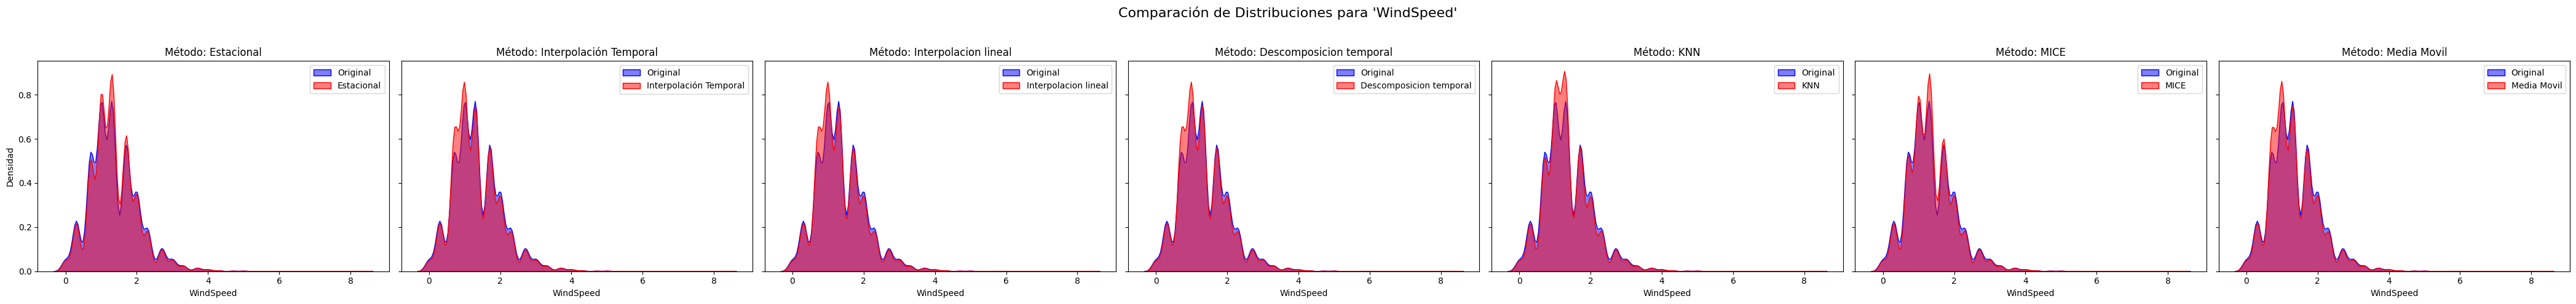

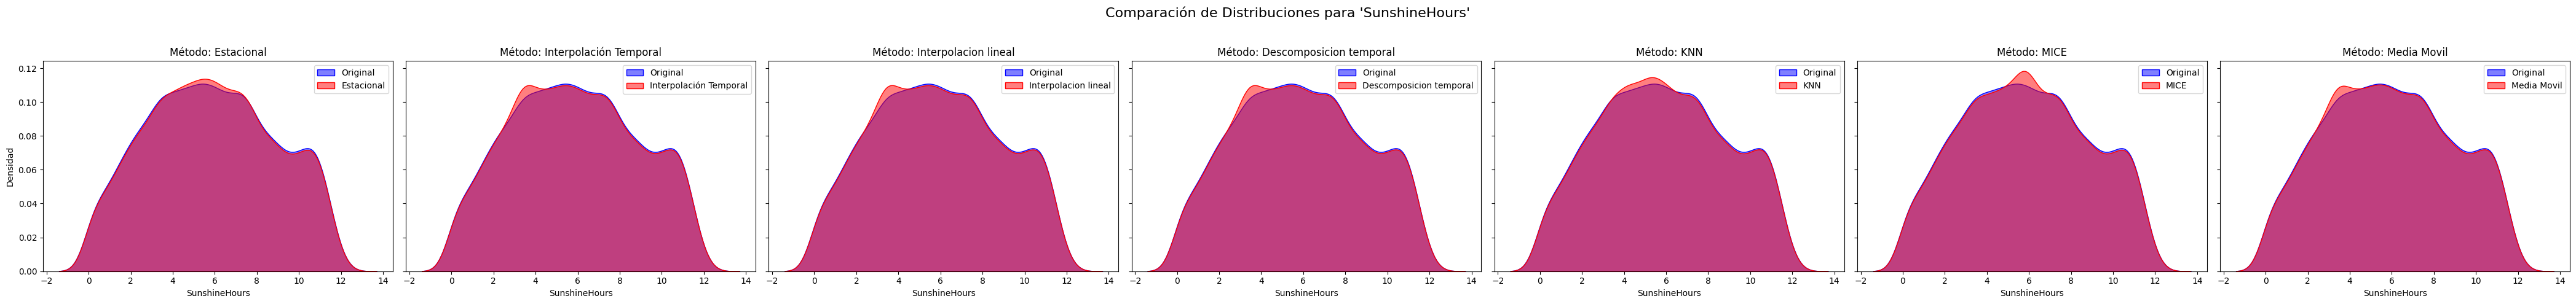

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

def comparar_distribuciones_lado_a_lado(df_original, df_imputados, variable, etiquetas, titulo=None):
    """
    Grafica las distribuciones de una variable antes y después de la imputación,
    mostrando los gráficos de los distintos métodos de imputación lado a lado.

    :param df_original: DataFrame con los datos originales.
    :param df_imputados: Lista de DataFrames con los datos imputados.
    :param variable: Nombre de la variable a comparar.
    :param etiquetas: Lista de etiquetas para cada DataFrame imputado.
    :param titulo: Título opcional para el conjunto de gráficos.
    """
    num_metodos = len(df_imputados)
    fig, axes = plt.subplots(1, num_metodos, figsize=(6 * num_metodos, 5), sharey=True)

    if titulo:
        fig.suptitle(titulo, fontsize=16)

    for ax, df_imputado, etiqueta in zip(axes, df_imputados, etiquetas):
        sns.kdeplot(df_original[variable].dropna(), label="Original", fill=True, alpha=0.5, color="blue", ax=ax)
        sns.kdeplot(df_imputado[variable].dropna(), label=etiqueta, fill=True, alpha=0.5, color="red", ax=ax)
        ax.set_title(f"Método: {etiqueta}")
        ax.set_xlabel(variable)
        ax.set_ylabel("Densidad")
        ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Lista de columnas a evaluar
columnas_a_imputar = ['DailyPrecipitation', 'AverageTemperature', 'RelativeHumidity', 'AtmosphericPressure', 'WindSpeed', 'SunshineHours']

# Lista de DataFrames imputados y sus etiquetas correspondientes
dataframes_imputados = [df_imputacion_estacional, df_imputacion_interpolacion_temporal, df_imputacion_interpolacion_lineal, df_imputacion_descomposicion_temporal, df_imputacion_knn, df_imputacion_mice, df_imputacion_media_movil]
etiquetas_imputados = ["Estacional", "Interpolación Temporal", "Interpolacion lineal", "Descomposicion temporal", "KNN", "MICE","Media Movil"]


# Generar los gráficos de comparación para cada variable
for columna in columnas_a_imputar:
    comparar_distribuciones_lado_a_lado(df_procesado, dataframes_imputados, columna, etiquetas_imputados,
                                        titulo=f"Comparación de Distribuciones para '{columna}'")

Densidades

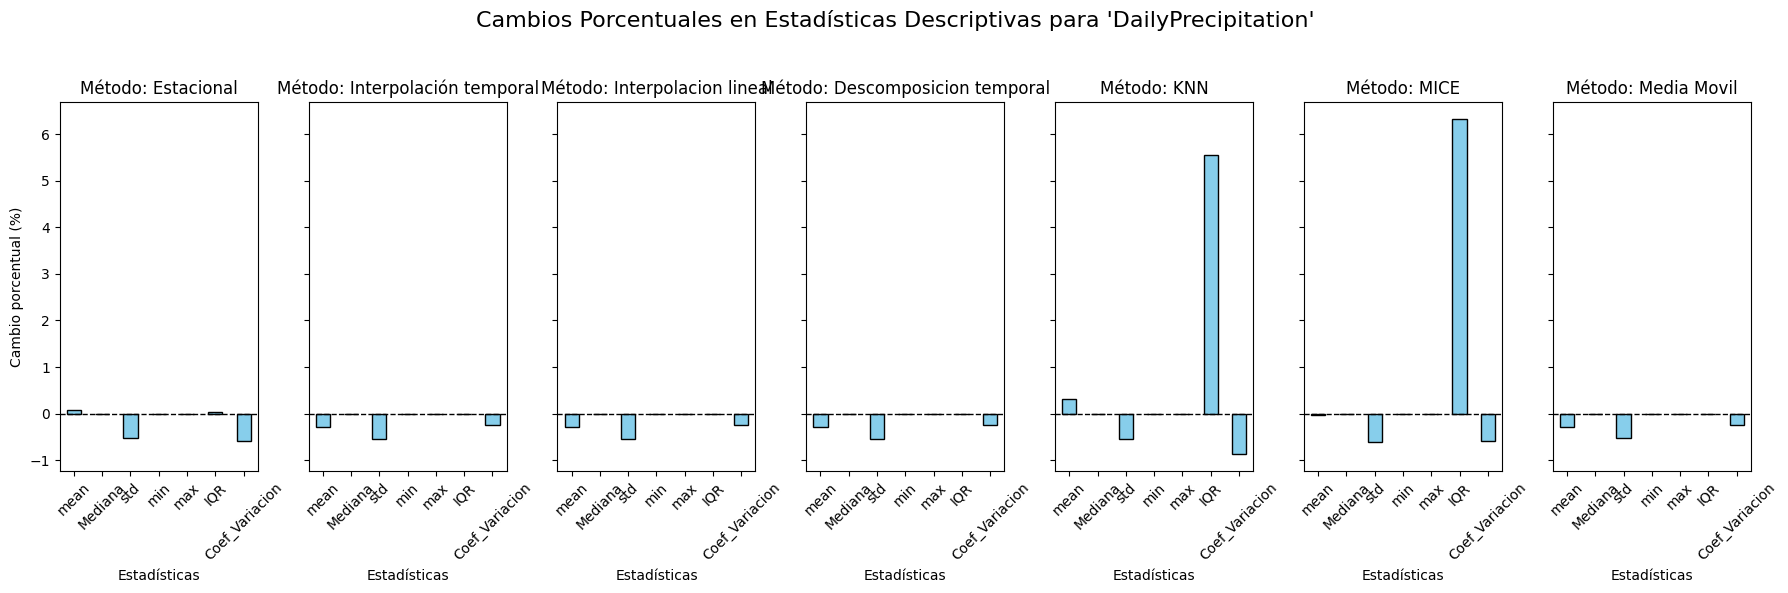

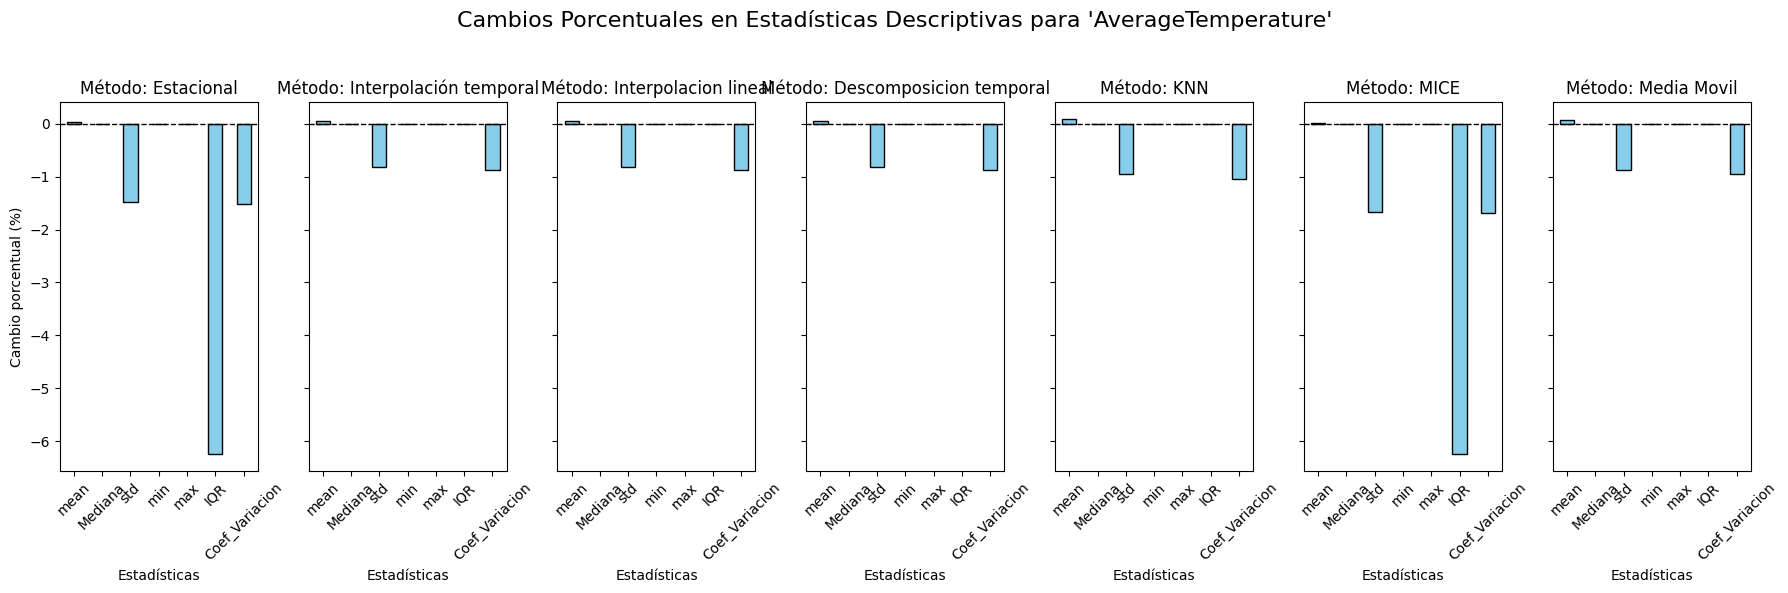

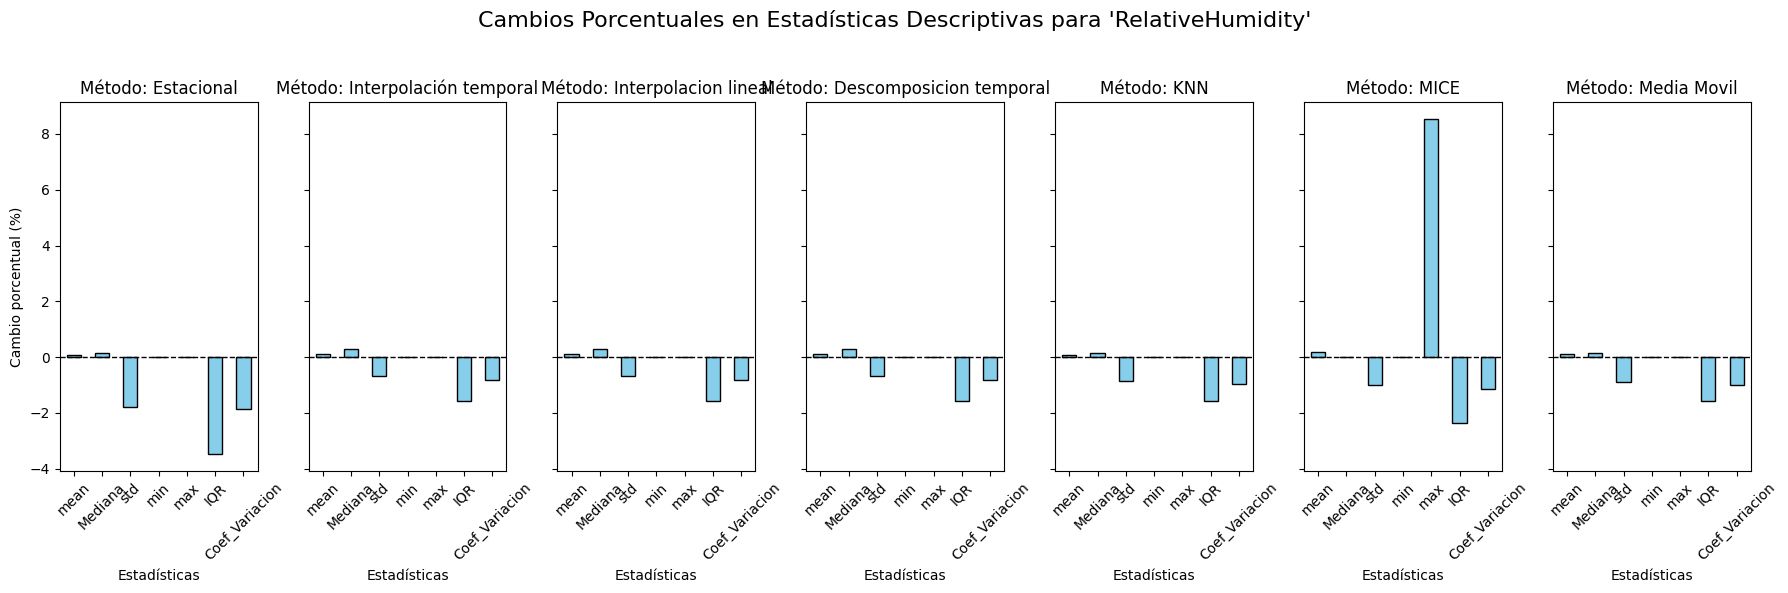

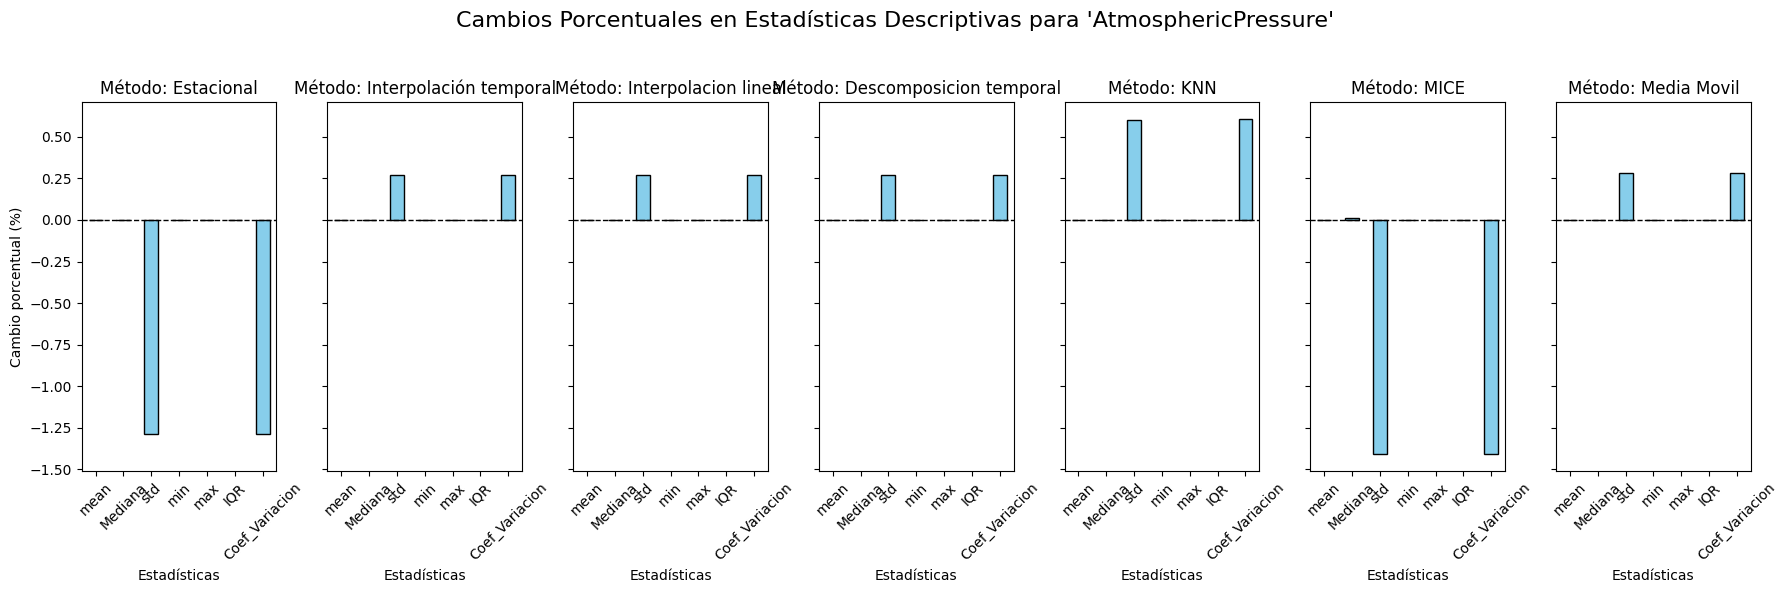

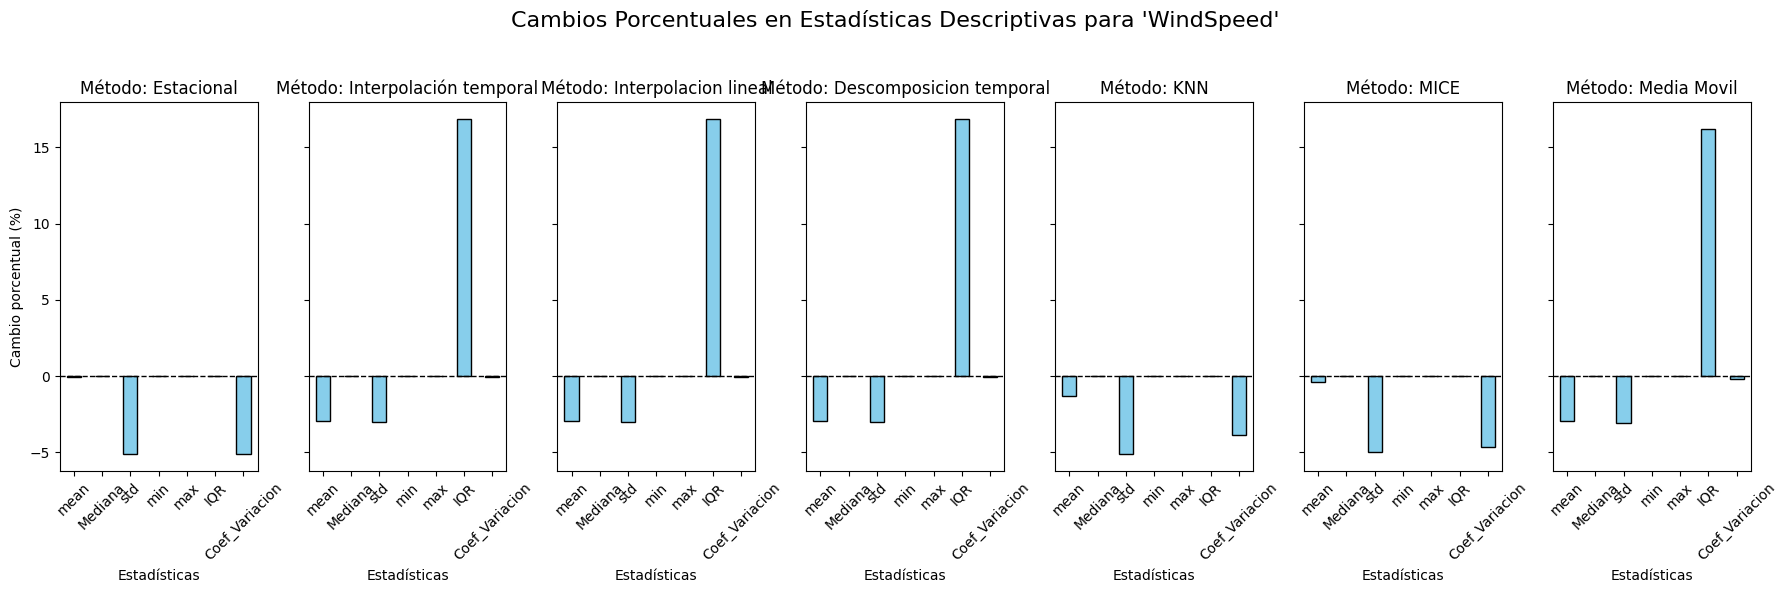

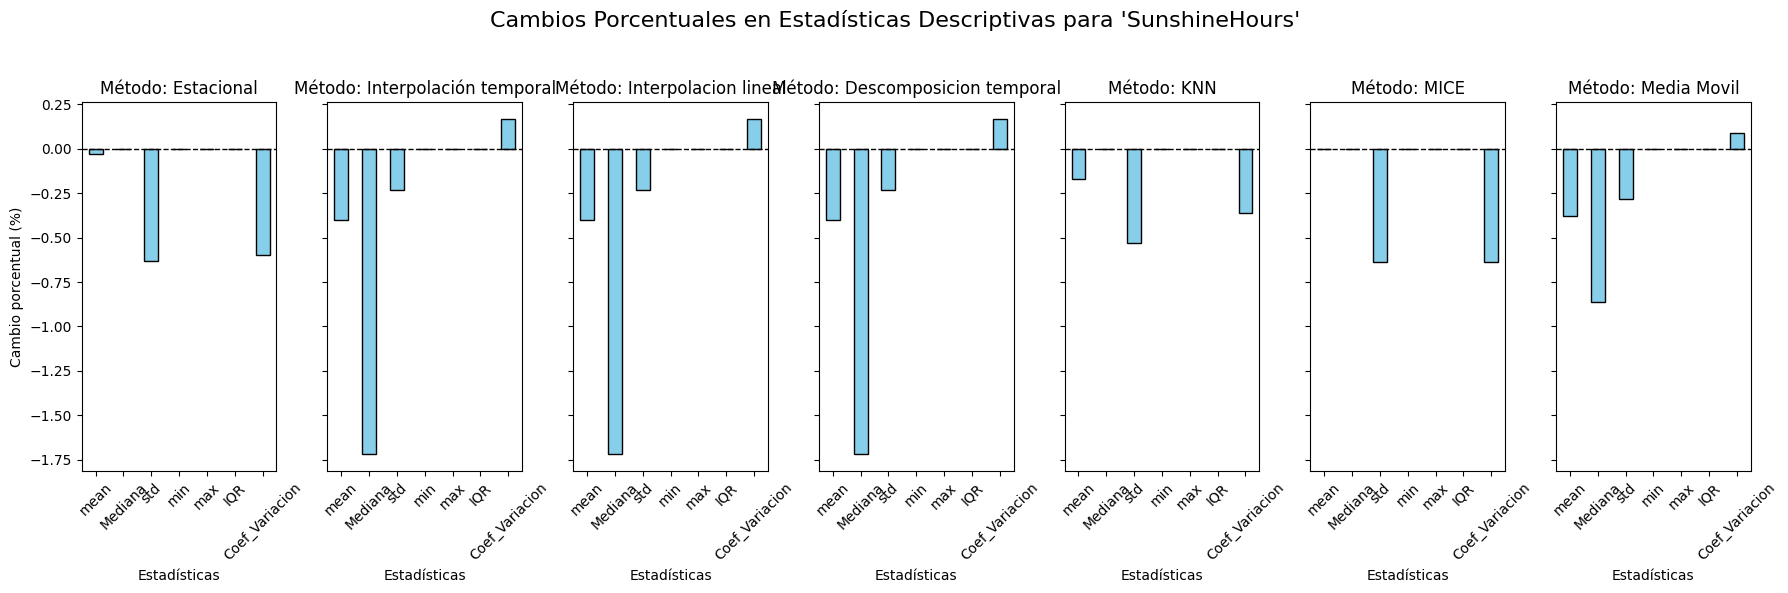

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis, skew

def filtrar_variables_ambientales(df):
    """Excluye las columnas 'Year', 'Month' y 'Day' para analizar solo las variables ambientales."""
    return df.drop(columns=["Year", "Month", "Day"], errors="ignore")

def calcular_estadisticas(df):
    """Calcula estadísticas descriptivas extendidas para cada variable numérica."""
    stats = df.describe().T
    stats["Mediana"] = df.median()
    #stats["Curtosis"] = df.apply(kurtosis)
    #stats["Asimetría"] = df.apply(skew)
    stats["IQR"] = stats["75%"] - stats["25%"]
    stats["Coef_Variacion"] = stats["std"] / stats["mean"]
    #return stats[["mean", "Mediana", "std", "min", "max", "IQR", "Coef_Variacion", "Curtosis", "Asimetría"]]
    return stats[["mean", "Mediana", "std", "min", "max", "IQR", "Coef_Variacion"]]

def evaluar_cambios_estadisticos(df_original, df_imputado):
    """Compara estadísticas antes y después de la imputación en variables ambientales."""
    df_original = filtrar_variables_ambientales(df_original)
    df_imputado = filtrar_variables_ambientales(df_imputado)

    stats_antes = calcular_estadisticas(df_original)
    stats_despues = calcular_estadisticas(df_imputado)

    # Calcular diferencia porcentual
    cambios_pct = ((stats_despues - stats_antes) / stats_antes) * 100
    cambios_pct = cambios_pct.replace([np.inf, -np.inf], np.nan)

    return cambios_pct.round(2)

def graficar_cambios_por_variable(cambios_dict, variable):
    """Genera gráficos de barras para las diferencias porcentuales de una variable específica en cada método de imputación."""
    fig, axes = plt.subplots(1, len(cambios_dict), figsize=(18, 6), sharey=True)
    fig.suptitle(f"Cambios Porcentuales en Estadísticas Descriptivas para '{variable}'", fontsize=16)

    for ax, (metodo, cambios) in zip(axes, cambios_dict.items()):
        if variable in cambios.index:
            cambios_var = cambios.loc[variable]
            cambios_var.plot(kind='bar', ax=ax, color='skyblue', edgecolor='black')
            ax.axhline(0, color='black', linewidth=1, linestyle='--')
            ax.set_title(f"Método: {metodo}")
            ax.set_ylabel("Cambio porcentual (%)")
            ax.set_xlabel("Estadísticas")
            ax.tick_params(axis='x', rotation=45)
        else:
            ax.set_visible(False)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Ejemplo de uso:

# Evaluar cambios estadísticos para cada método de imputación
cambios_pct_estacional = evaluar_cambios_estadisticos(df_procesado, df_imputacion_estacional)
cambios_pct_interpolacion_temporal = evaluar_cambios_estadisticos(df_procesado, df_imputacion_interpolacion_temporal)
cambios_pct_interpolacion_lineal = evaluar_cambios_estadisticos(df_procesado, df_imputacion_interpolacion_lineal)
cambios_pct_descomposicion_temporal = evaluar_cambios_estadisticos(df_procesado,df_imputacion_descomposicion_temporal )
cambios_pct_knn = evaluar_cambios_estadisticos(df_procesado, df_imputacion_knn)
cambios_pct_mice = evaluar_cambios_estadisticos(df_procesado, df_imputacion_mice)
cambios_pct_media_movil = evaluar_cambios_estadisticos(df_procesado, df_imputacion_media_movil)

# Almacenar los cambios en un diccionario para facilitar el acceso
cambios_dict = {
    'Estacional': cambios_pct_estacional,
    'Interpolación temporal': cambios_pct_interpolacion_temporal,
    'Interpolacion lineal': cambios_pct_interpolacion_lineal,
    'Descomposicion temporal': cambios_pct_descomposicion_temporal,
    'KNN': cambios_pct_knn,
    'MICE': cambios_pct_mice,
    'Media Movil': cambios_pct_media_movil
}

# Lista de variables a analizar
variables_a_analizar = ['DailyPrecipitation', 'AverageTemperature', 'RelativeHumidity', 'AtmosphericPressure', 'WindSpeed', 'SunshineHours']

# Generar gráficos para cada variable
for variable in variables_a_analizar:
    graficar_cambios_por_variable(cambios_dict, variable)

## 2. EVALUACION DE LA DINAMICA TEMPORAL

Funciones de Autocorrelación:

* ACF (Función de Autocorrelación): Compara los gráficos ACF de la serie original e imputada para asegurarte de que se preserven las correlaciones a distintos rezagos.

* PACF (Función de Autocorrelación Parcial): Verifica que la dependencia directa entre observaciones se mantenga tras la imputación.

* EACF (Función de Autocorrelación Extendida): Es especialmente útil para identificar estructuras ARMA en series con componentes estacionales y no estacionales.

Preservación de Componentes de la Serie:

* Análisis de Descomposición: Utiliza métodos como STL o descomposición clásica para separar la serie en sus componentes (tendencia, estacionalidad y residual) antes y después de la imputación.

* Verifica que la amplitud y fase de los ciclos estacionales, así como la tendencia general, se mantengan, lo cual es crítico para variables como precipitación y temperatura.



Para elegir el mejor método de imputación, considera los siguientes criterios basados en los resultados obtenidos:

1. Preservación de la Dependencia Temporal (ACF y PACF)
ACF Diff y PACF Diff (Diferencia de ACF y PACF)

Menor valor es mejor: Una menor diferencia indica que el método de imputación mantiene mejor la estructura de correlación temporal.

Interpretación: Si los valores son altos, significa que la imputación ha alterado significativamente la relación entre observaciones a diferentes rezagos, lo que puede afectar la calidad del modelo predictivo.

2. Conservación de Componentes de la Serie Temporal
Tendencia Corr (Correlación de la Tendencia)

Más cercano a 1 es mejor: Indica que la tendencia general de la serie antes y después de la imputación es similar.

Interpretación: Un valor bajo sugiere que el método ha alterado la evolución a largo plazo de la variable.

Estacionalidad Corr (Correlación de la Estacionalidad)

Más cercano a 1 es mejor: Indica que la estructura estacional no se ha visto afectada por la imputación.

Importante para: Variables con ciclos claros, como temperatura o precipitación.

Residuo RMSE (Error Cuadrático Medio del Residuo)

Menor valor es mejor: Indica que las fluctuaciones residuales son similares antes y después de la imputación.

Interpretación: Un valor alto puede indicar que la imputación ha generado ruido adicional o alterado la variabilidad natural de la serie.

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import STL

# VARIABLES A EVALUAR
columnas_a_imputar = ['DailyPrecipitation', 'AverageTemperature', 'RelativeHumidity',
                      'AtmosphericPressure', 'WindSpeed', 'SunshineHours']

# Función para calcular diferencia de ACF y PACF
def calcular_acf_pacf_diferencia(original, imputado, lags=30):
    original = original.dropna()
    imputado = imputado.dropna()
    min_len = min(len(original), len(imputado))
    original, imputado = original.iloc[:min_len], imputado.iloc[:min_len]

    acf_orig = acf(original, nlags=lags, fft=False)
    acf_imp = acf(imputado, nlags=lags, fft=False)
    pacf_orig = pacf(original, nlags=lags)
    pacf_imp = pacf(imputado, nlags=lags)

    acf_diff = np.mean(np.abs(acf_orig - acf_imp))
    pacf_diff = np.mean(np.abs(pacf_orig - pacf_imp))
    return acf_diff, pacf_diff

# Función para calcular preservación de componentes temporales
def calcular_preservacion_componentes(original, imputado, periodo_estacional=365):
    original = original.dropna()
    imputado = imputado.dropna()
    min_len = min(len(original), len(imputado))
    original, imputado = original.iloc[:min_len], imputado.iloc[:min_len]

    stl_orig = STL(original, period=periodo_estacional).fit()
    stl_imp = STL(imputado, period=periodo_estacional).fit()

    tendencia_corr = np.corrcoef(stl_orig.trend, stl_imp.trend)[0, 1]
    estacionalidad_corr = np.corrcoef(stl_orig.seasonal, stl_imp.seasonal)[0, 1]
    residuo_rmse = np.sqrt(np.mean((stl_orig.resid - stl_imp.resid) ** 2))

    return tendencia_corr, estacionalidad_corr, residuo_rmse

# DICCIONARIO DE IMPUTACIONES
df_imputaciones = {
    'Media Móvil': df_imputacion_media_movil,
    'Estacional': df_imputacion_estacional,
    'Interpolación Temporal': df_imputacion_interpolacion_temporal,
    'Interpolación Lineal': df_imputacion_interpolacion_lineal,
    'Descomposición Temporal': df_imputacion_descomposicion_temporal,
    'KNN': df_imputacion_knn,
    'MICE': df_imputacion_mice
}

# EVALUACIÓN
resultados = []
for metodo, df_imputado in df_imputaciones.items():
    for variable in columnas_a_imputar:
        original = df_procesado[variable]
        imputado = df_imputado[variable]

        acf_diff, pacf_diff = calcular_acf_pacf_diferencia(original, imputado)
        tendencia_corr, estacionalidad_corr, residuo_rmse = calcular_preservacion_componentes(original, imputado)

        # Score final que combina todos los criterios (entre mayor, mejor)
        score_final = (tendencia_corr + estacionalidad_corr) / (1 + acf_diff + pacf_diff + residuo_rmse)

        resultados.append([
            metodo, variable,
            acf_diff, pacf_diff,
            tendencia_corr, estacionalidad_corr,
            residuo_rmse, score_final
        ])

# DataFrame con resultados completos
df_resultados = pd.DataFrame(resultados, columns=[
    'Método', 'Variable',
    'ACF Diff', 'PACF Diff',
    'Tendencia Corr', 'Estacionalidad Corr',
    'Residuo RMSE', 'Score Final'
])

# Seleccionar el mejor método por variable
df_mejores = df_resultados.sort_values(
    by=['Variable', 'Score Final'],
    ascending=[True, False]
).groupby('Variable').first().reset_index()

# Agregar justificación del por qué es el mejor método
def justificar_fila(row):
    justificacion = f"Seleccionado por mejor balance: "
    justificacion += f"alta correlación en tendencia ({row['Tendencia Corr']:.2f}), "
    justificacion += f"alta estacionalidad ({row['Estacionalidad Corr']:.2f}), "
    justificacion += f"bajas diferencias en ACF ({row['ACF Diff']:.3f}) y PACF ({row['PACF Diff']:.3f}), "
    justificacion += f"y bajo RMSE del residuo ({row['Residuo RMSE']:.3f})."
    return justificacion

df_mejores['Justificación'] = df_mejores.apply(justificar_fila, axis=1)

# Mostrar resultados
print("Mejor método por variable basado en la dinámica temporal:")
display(df_mejores)

# También puedes exportar a CSV si lo deseas
# df_mejores.to_csv("mejores_metodos_dinamica_temporal.csv", index=False)


Mejor método por variable basado en la dinámica temporal:


,Variable,Método,ACF Diff,PACF Diff,Tendencia Corr,Estacionalidad Corr,Residuo RMSE,Score Final,Justificación
0,AtmosphericPressure,KNN,0.012124,0.001720,0.972639,0.412048,0.260795,1.086337,Seleccionado por mejor balance: alta correlaci...
1,AverageTemperature,Estacional,0.018653,0.005664,0.893678,0.089500,0.507880,0.641679,Seleccionado por mejor balance: alta correlaci...
2,DailyPrecipitation,MICE,0.001047,0.000775,0.961227,0.526567,0.674820,0.887366,Seleccionado por mejor balance: alta correlaci...
3,RelativeHumidity,Interpolación Lineal,0.004962,0.006996,0.934981,0.013818,3.985406,0.189860,Seleccionado por mejor balance: alta correlaci...
4,SunshineHours,MICE,0.001534,0.001877,0.960033,0.140830,1.023160,0.543214,Seleccionado por mejor balance: alta correlaci...
5,WindSpeed,Estacional,0.015051,0.007243,0.557916,0.003350,0.318578,0.418583,Seleccionado por mejor balance: alta correlaci...


## 3. EVALUACION DE LA ESTRUCTURA TEMPORAL Y LA COMPLEJIDAD

* Estadísticos de Reversibilidad Temporal:

  Calcula coeficientes que midan la simetría temporal y compáralos antes y después de la imputación para detectar cambios en la dinámica de la serie.

* Cruces por Cero y Persistencia:

  Analiza la frecuencia de cruces por el nivel medio y la duración de periodos por encima o por debajo de ciertos umbrales, lo que es útil para detectar alteraciones en variables como precipitación o velocidad del viento.

* Análisis de Recurrencia:

  Utiliza gráficos de recurrencia (RP) y análisis de cuantificación de recurrencia (RQA) para evaluar métricas como determinismo, entropía y laminaridad, permitiendo detectar cambios sutiles en la dinámica temporal.

* Métricas de Información:

  Calcula la entropía aproximada (ApEn), la entropía muestral (SampEn) o la información mutua en distintos rezagos. Estas medidas ayudan a identificar alteraciones en la complejidad y predictibilidad de la serie.

In [23]:
!pip install antropy pyunicorn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 26.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 59.0 MB/s eta 0:00:00
  Created wheel for pyunicorn: filename=pyunicorn-0.8.2-cp311-cp311-linux_x86_64.whl size=2538486 sha256=fe04ca23ac63acf3df1afe981952a07008b3314892dff5f6bc712830954b954f
  Stored in directory: /root/.cache/pip/wheels/98/f0/91/107788ca969f11365d8f022a764cc5fda26919de57ca23cecb
Successfully built pyunicorn


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from antropy import sample_entropy, app_entropy
from pyunicorn.timeseries import RecurrencePlot
from scipy.stats import entropy
from sklearn.preprocessing import MinMaxScaler

# Funciones para evaluar estructura temporal y complejidad
def calcular_reversibilidad_temporal(serie):
    serie = serie.dropna()
    if len(serie) < 10:
        return np.nan
    return np.mean(np.abs(serie.diff().dropna()))

def calcular_cruces_por_cero(serie):
    serie = serie.dropna()
    if len(serie) < 10:
        return np.nan
    return np.sum(np.diff(np.sign(serie - serie.mean())) != 0)

def calcular_recurrencia(serie, threshold=0.1):
    serie = serie.dropna().values
    if len(serie) < 10:
        return np.nan, np.nan, np.nan
    try:
        rp = RecurrencePlot(serie, threshold=threshold)
        determinismo = rp.determinism()
        laminaridad = rp.laminarity()
        rec_matrix = rp.recurrence_matrix()
        histograma = np.sum(rec_matrix, axis=1)
        entropia_rqa = entropy(histograma + 1e-10)
        return determinismo, entropia_rqa, laminaridad
    except:
        return np.nan, np.nan, np.nan

def calcular_entropias(serie):
    serie = serie.dropna().values
    if len(serie) < 10:
        return np.nan, np.nan
    return sample_entropy(serie), app_entropy(serie)


# Evaluar métodos de imputación (estructura temporal y complejidad)
# Diccionario con los dataframes imputados
df_imputaciones = {
    'Media Móvil': df_imputacion_media_movil,
    'Estacional': df_imputacion_estacional,
    'Interpolación Temporal': df_imputacion_interpolacion_temporal,
    'Interpolación Lineal': df_imputacion_interpolacion_lineal,
    'Descomposición Temporal': df_imputacion_descomposicion_temporal,
    'KNN': df_imputacion_knn,
    'MICE': df_imputacion_mice
}

# Lista de variables imputadas
estructura_resultados = []

for metodo, df in df_imputaciones.items():
    for var in columnas_a_imputar:
        serie = df[var]
        if serie.isnull().sum() > 0 or len(serie.dropna()) < 10:
            continue

        rev = calcular_reversibilidad_temporal(serie)
        cruz = calcular_cruces_por_cero(serie)
        det, ent_rqa, lam = calcular_recurrencia(serie)
        sampen, apen = calcular_entropias(serie)

        estructura_resultados.append([
            metodo, var, rev, cruz, det, ent_rqa, lam, sampen, apen
        ])
# Crear DataFrame de evaluación
df_eval = pd.DataFrame(estructura_resultados, columns=[
    'Método', 'Variable', 'Reversibilidad', 'Cruces Cero',
    'Determinismo', 'Entropía RQA', 'Laminaridad',
    'SampEn', 'ApEn'
])

# Normalizar métricas y calcular score estructural
# Normalizar todas las métricas por variable
metricas_a_normalizar = [
    'Reversibilidad', 'Cruces Cero', 'Determinismo',
    'Laminaridad', 'Entropía RQA', 'SampEn', 'ApEn'
]

df_norm = df_eval.copy()

for var in columnas_a_imputar:
    df_var = df_eval[df_eval['Variable'] == var].copy()
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_var[metricas_a_normalizar]),
                             columns=metricas_a_normalizar)
    df_norm.loc[df_var.index, metricas_a_normalizar] = df_scaled.values

# Calcular score: mayor es mejor
df_norm['Score Estructura'] = (
    df_norm['Reversibilidad'] + df_norm['Cruces Cero'] +
    df_norm['Determinismo'] + df_norm['Laminaridad']
) - (
    df_norm['Entropía RQA'] + df_norm['SampEn'] + df_norm['ApEn']
)

# Seleccionar el mejor método por variable
df_mejores = df_norm.sort_values(
    by=['Variable', 'Score Estructura'], ascending=[True, False]
).groupby('Variable').first().reset_index()

print("✅ Mejores métodos por estructura temporal:")
print(df_mejores[['Variable', 'Método', 'Score Estructura']])

# Guardar en archivo CSV
#df_mejores.to_csv('mejores_metodos_por_variable.csv', index=False)

# Visualización de los resultados
plt.figure(figsize=(12, 6))
sns.barplot(data=df_norm, x='Variable', y='Score Estructura', hue='Método')
plt.xticks(rotation=45)
plt.title("Score de estructura temporal por variable y método de imputación")
plt.tight_layout()
plt.show()


# Resumen final
resumen = df_mejores[['Variable', 'Método']].rename(columns={'Método': 'Mejor Método'})
print("📌 Resumen por variable:")
print(resumen)




Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...


In [ ]:
import numpy as np
import pandas as pd
from antropy import sample_entropy, app_entropy
from pyunicorn.timeseries import RecurrencePlot
from scipy.stats import entropy

# Funciones para evaluar estructura temporal y complejidad
def calcular_reversibilidad_temporal(serie):
    return np.mean(np.abs(serie.diff().dropna()))

def calcular_cruces_por_cero(serie):
    return np.sum(np.diff(np.sign(serie - serie.mean())) != 0)

def calcular_recurrencia(serie, threshold=0.1):
    serie = serie.dropna().values  # Convertir a array eliminando NaN
    rp = RecurrencePlot(serie, threshold=threshold)
    determinismo = rp.determinism()
    laminaridad = rp.laminarity()
    rec_matrix = rp.recurrence_matrix()
    histograma = np.sum(rec_matrix, axis=1)
    entropia_rqa = entropy(histograma + 1e-10)
    return determinismo, entropia_rqa, laminaridad

def calcular_entropia(serie):
    serie = serie.dropna().values
    return sample_entropy(serie, 2, 0.2 * np.std(serie)), app_entropy(serie, 2, 0.2 * np.std(serie))

# Diccionario con dataframes de imputaciones
df_imputaciones = {
    'Media Móvil': df_imputacion_media_movil,
    'Estacional': df_imputacion_estacional,
    'Interpolación Temporal': df_imputacion_interpolacion_temporal,
    'Interpolación Lineal': df_imputacion_interpolacion_lineal,
    'Descomposición Temporal': df_imputacion_descomposicion_temporal,
    'KNN': df_imputacion_knn,
    'MICE': df_imputacion_mice
}

# Evaluación de cada método por variable ambiental
estructura_resultados = []
for metodo, df_imputado in df_imputaciones.items():
    for variable in columnas_a_imputar:
        imputado = df_imputado[variable]

        reversibilidad = calcular_reversibilidad_temporal(imputado)
        cruces_cero = calcular_cruces_por_cero(imputado)
        recurrencia = calcular_recurrencia(imputado)
        entropia_samp, entropia_aprox = calcular_entropia(imputado)

        score_estructura = (reversibilidad + cruces_cero + recurrencia[0]) / (1 + entropia_samp + entropia_aprox)
        estructura_resultados.append([metodo, variable, reversibilidad, cruces_cero, recurrencia[0], recurrencia[1], recurrencia[2], entropia_samp, entropia_aprox, score_estructura])

# Crear DataFrame con los resultados
df_estructura = pd.DataFrame(estructura_resultados, columns=['Método', 'Variable', 'Reversibilidad', 'Cruces Cero', 'Determinismo', 'Entropía RQA', 'Laminaridad', 'Entropía SampEn', 'Entropía ApEn', 'Score Estructura'])

# Obtener mejores métodos
df_mejores_estructura = df_estructura.sort_values(by=['Variable', 'Score Estructura'], ascending=[True, False]).groupby('Variable').first().reset_index()
print(df_mejores_estructura)

# Guardar resultados
df_mejores_estructura.to_csv('evaluacion_estructura_temporal.csv', index=False)


Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the supremum distance matrix...


## 4. CONSERVACION DE EVENTOS EXTREMOS
* Eventos Máximos y Mínimos:

  Analiza la distribución de valores extremos (máximos y mínimos) por periodos y verifica que la intensidad y frecuencia de estos eventos se mantengan tras la imputación, aspecto especialmente relevante en variables ambientales.
